# Machine Learning Application in Finance
# &emsp; NNO6459-BNNO1, Spring 2021

### &emsp; &emsp; Professor: Philip Sun
### &emsp; &emsp; Email: philip.sun@faculty.hult.edu
### &emsp; &emsp; Last Modified: 3/1/2021

___

## Class 3: Bankruptcy, Logistic Regression, and Neural Networks


## &emsp; Ex1 Predict Company Bankcruptcy

In [1]:
# import modules
import math
import numpy as np
import pandas as pd

## 1.1 Inspect Dataset

In [2]:
# import bankruptcy data
# download the following data file from mycourse page, and store it in the same directory as the notebook file
csv_file='CompanyBankruptcy_Clean.csv'
df_bankruptcy=pd.read_csv(csv_file, index_col=0)
df_bankruptcy

,Bankrupt?,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,operating gross margin,realized sales gross margin,operating profit rate,tax Pre-net interest rate,after-tax net interest rate,non-industry income and expenditure/revenue,...,one if total liabilities exceeds total assets zero otherwise,net income to total assets,No-credit interval,Gross profit to Sales,Net income to stockholder's Equity,liability to equity,Degree of financial leverage (DFL),Interest coverage ratio( Interest expense to EBIT ),one if net income was negative for the last two year zero otherwise,equity to liability
0,1,0.370594,0.424389,0.405750,0.601457,0.601457,0.998969,0.796887,0.808809,0.302646,...,0,0.716845,0.622879,0.601453,0.827890,0.290202,0.026601,0.564050,1,0.016469
1,1,0.464291,0.538214,0.516730,0.610235,0.610235,0.998946,0.797380,0.809301,0.303556,...,0,0.795297,0.623652,0.610237,0.839969,0.283846,0.264577,0.570175,1,0.020794
2,1,0.426071,0.499019,0.472295,0.601450,0.601364,0.998857,0.796403,0.808388,0.302035,...,0,0.774670,0.623841,0.601449,0.836774,0.290189,0.026555,0.563706,1,0.016474
3,1,0.399844,0.451265,0.457733,0.583541,0.583541,0.998700,0.796967,0.808966,0.303350,...,0,0.739555,0.622929,0.583538,0.834697,0.281721,0.026697,0.564663,1,0.023982
4,1,0.465022,0.538432,0.522298,0.598783,0.598783,0.998973,0.797366,0.809304,0.303475,...,0,0.795016,0.623521,0.598782,0.839973,0.278514,0.024752,0.575617,1,0.035490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6814,0,0.493687,0.539468,0.543230,0.604455,0.604462,0.998992,0.797409,0.809331,0.303510,...,0,0.799927,0.623620,0.604455,0.840359,0.279606,0.027064,0.566193,1,0.029890
6815,0,0.475162,0.538269,0.524172,0.598308,0.598308,0.998992,0.797414,0.809327,0.303520,...,0,0.799748,0.623931,0.598306,0.840306,0.278132,0.027009,0.566018,1,0.038284
6816,0,0.472725,0.533744,0.520638,0.610444,0.610213,0.998984,0.797401,0.809317,0.303512,...,0,0.797778,0.624156,0.610441,0.840138,0.275789,0.026791,0.565158,1,0.097649
6817,0,0.506264,0.559911,0.554045,0.607850,0.607850,0.999074,0.797500,0.809399,0.303498,...,0,0.811808,0.623957,0.607846,0.841084,0.277547,0.026822,0.565302,1,0.044009


Text(0.5, 0, 'Interest coverage ratio( Interest expense to EBIT )')

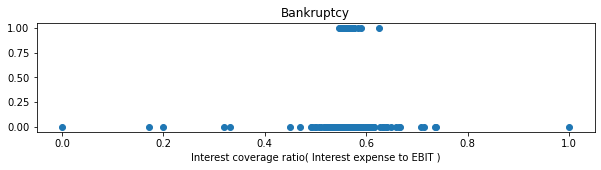

In [194]:
# draw scatter plot(s) for class slides:

#xlabel='liability to equity'
#xlabel='Degree of financial leverage (DFL)'
xlabel='Interest coverage ratio( Interest expense to EBIT )'

x=df_bankruptcy[xlabel]
y=df_bankruptcy['Bankrupt?']

# Plot
import matplotlib.pyplot as plt
%matplotlib inline 

plt.figure(figsize=(10,2))

plt.scatter(x, y)
plt.title('Bankruptcy')
plt.xlabel(xlabel)

In [196]:
# compute and output some summary statistics

def stat_summary(df_data, to_print):
    import numpy as np
    import pandas as pd
    stat_count=len(df_data.index)
    stat_mean=np.mean(df_data)
    stat_std=np.std(df_data)
    stat_max=np.max(df_data)
    stat_90pct=np.percentile(df_data, 90)
    stat_median=np.median(df_data)
    stat_min=np.min(df_data)

        
    #return
    df_stat_summary=pd.DataFrame({'count': len(df_data.index),
                    'mean': np.mean(df_data, axis=0),
                    'stdev': np.std(df_data, axis=0),
                    'stat_max': np.max(df_data, axis=0),
                    'stat_90pct': np.percentile(df_data, 90, axis=0),
                    'stat_75pct': np.percentile(df_data, 75, axis=0),
                    'stat_media': np.median(df_data, axis=0),
                    'stat_25pct': np.percentile(df_data, 25, axis=0),
                    'stat_10pct': np.percentile(df_data, 10, axis=0),
                    'stat_min': np.min(df_data, axis=0)} ,
                     index = df_data.columns)
    
    #print?
    if to_print:
        print(df_stat_summary)
        
    return df_stat_summary
# end of function stat_summary


df_stat=stat_summary(df_bankruptcy, False)
df_stat.to_csv('csv_out.csv') # this is the .csv output file.  open to view

In [49]:
# NOTE, the dataset has been cleaned to remove some outliers.  following were codes used to clean the original data from kaggle.com
# csv_file='CompanyBankruptcy.csv'
# df_bankruptcy=pd.read_csv(csv_file, index_col=0)
# df_bankruptcy.drop(df_bankruptcy.columns[df_stat['stat_max']>1.0e+8], axis=1, inplace=True)
# df_bankruptcy.dropna
# df_bankruptcy.to_csv('CompanyBankruptcy_Clean.csv')

## 1.2 Logistic Regression

In [197]:
# let's first split the data set
from sklearn.model_selection import train_test_split
X=np.array(df_bankruptcy.iloc[:,1:]) # get features from df, convert to array for easy numerical operation
y=np.array(df_bankruptcy.iloc[:,0]) # get target, note y=1 for bankruptcy, 0 for no bankruptcy

# splitting into training, and test
# note: use stratify as y=1 is rare (~3% of total observation). stratify ensures that positives are split proportionally
Xtra, Xtest, ytra, ytest = train_test_split(X, y, stratify=y, test_size=0.20, random_state=0)
# further split training into train and validation
Xtra, Xval, ytra, yval = train_test_split(Xtra, ytra, stratify=ytra, test_size=0.25, random_state=0)
# final split is 60:20:20, tra:val:test

In [198]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression
Logit_Reg=LogisticRegression(random_state=0).fit(Xtra, ytra)

print('training score (accuracy):  ', Logit_Reg.score(Xtra,ytra))
print('validation score (accuracy):  ', Logit_Reg.score(Xval,yval))

training score (accuracy):   0.9709117575164996
validation score (accuracy):   0.967008797653959


In [199]:
# Take a Look at Prediction
decfun_val=Logit_Reg.decision_function(Xval)
print("Decision function, i.e. the linear function theta'*x: \n", decfun_val, "\n")
print("Decision function min: {:.2f} max: {:.2f} \n".format(np.min(decfun_val), np.max(decfun_val)))

prob_val=Logit_Reg.predict_proba(Xval)
print("Predicition probability, i.e. the sigmoid function g(theta*x): \n", prob_val[:,0], "\n")
print("Predicition probability min: {:.2f} max: {:.2f} \n".format(np.min(prob_val[:,0]), np.max(prob_val[:,0])))

Decision function, i.e. the linear function theta'*x: 
 [-2.80896605 -4.19877811 -4.32733405 ... -6.34150291 -5.46659652
 -4.66269985] 

Decision function min: -10.77 max: 4.17 

Predicition probability, i.e. the sigmoid function g(theta*x): 
 [0.94315841 0.98520817 0.98696934 ... 0.99824145 0.99579219 0.99064736] 

Predicition probability min: 0.02 max: 1.00 



## 1.3 Neural Network (Deep Learning)
In sklearn, the neural_network package is pretty good for small dataset.  for more computational demanding tasks check out kera, tensorflow, or other packages

In [200]:
from sklearn.neural_network import MLPClassifier

# there are many parameters here
# * solver (previously algorithm), default 'adam' does a good job.  other options like 'lbfgs' more robust but slower
# * activation is the function applied, there is 'tanh' is similar to sigmoid, 
#     it uses sigmoid tangent function betwee -1 and +1
# * max_iter gives the maximimun iteration (of gradient descent).  if opt does not converge, it will stop at max_iter.
#     we will start with 1000, and will increase to 10,000
# * alpha is the regularization parameter. higher alpha, means more regularization (i.e. shrink coef more)
# * hidden_layer, specifies how many hidden layer and how many nodes per layer.

nn_01 = MLPClassifier(solver='adam', activation='tanh', 
                      max_iter=1000, alpha=0.01, random_state=0, 
                      hidden_layer_sizes=[10, 10]).fit(Xtra, ytra)

print('training score (accuracy):  ', nn_01.score(Xtra,ytra))
print('validation score (accuracy):  ', nn_01.score(Xval,yval))

training score (accuracy):   0.9689562454167685
validation score (accuracy):   0.969208211143695


In [201]:
# what if we add a layer
nn_02 = MLPClassifier(solver='adam', activation='tanh', 
                      max_iter=10000, alpha=1, random_state=0, 
                      hidden_layer_sizes=[16, 8, 4]).fit(Xtra, ytra)

print('training score (accuracy):  ', nn_01.score(Xtra,ytra))
print('validation score (accuracy):  ', nn_01.score(Xval,yval))

training score (accuracy):   0.9689562454167685
validation score (accuracy):   0.969208211143695


## Assignment 3.a (graded) 
Run Neural Network fitting with 3 hidden layers with multiple alpha


In [12]:
# iterate through alpha in a range and collect scores, and print at the end. 
alpharange=[0.0001, 0.0003, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3]
hidden_layer=[16, 8, 4]
df_accuracy=pd.DataFrame([], index=alpharange, columns=['train','validation'])
for a in alpharange:
    # complete the code to fit MLPClassifier in this for loop
    nn_00 = MLPClassifier(solver='adam', activation='tanh', 
                      max_iter=10000, alpha=1, random_state=0, 
                      hidden_layer_sizes=[16, 8, 4]).fit(Xtra, ytra)

    
    # collect results, i.e. prediction scores
    df_accuracy.loc[a,:]=[nn_00.score(Xtra,ytra),nn_00.score(Xval,yval)]
    
df_accuracy

,train,validation
0.0001,0.970667,0.967742
0.0003,0.970667,0.967742
0.0010,0.970667,0.967742
0.0030,0.970667,0.967742
0.0100,0.970667,0.967742
0.0300,0.970667,0.967742
0.1000,0.970667,0.967742
0.3000,0.970667,0.967742
1.0000,0.970667,0.967742
3.0000,0.970667,0.967742


## Assignment 3.b (graded)
run Neural Network fitting with randomized initialization, and collect the accuracy scores in a dataframe indexed by the random seed.

In [18]:
# iterate through alpha in a range and collect scores, and print at the end. 
alpha_value=0.01
hidden_layer=[16, 8, 4]
df_accuracy=pd.DataFrame([], index=range(10), columns=['train','validation'])
for i in range(10):
    # complete the code to fit MLPClassifier in this for loop
    nn_01= MLPClassifier(solver='adam', activation='tanh', 
                      max_iter=10000, alpha=0.01, random_state=0, 
                      hidden_layer_sizes=[16, 8, 4]).fit(Xtra, ytra)
    
    # collect results, i.e. prediction scores
    df_accuracy.loc[i,:]=[nn_01.score(Xtra,ytra), nn_01.score(Xval,yval)]
    
df_accuracy


,train,validation
0,0.969934,0.970674
1,0.969934,0.970674
2,0.969934,0.970674
3,0.969934,0.970674
4,0.969934,0.970674
5,0.969934,0.970674
6,0.969934,0.970674
7,0.969934,0.970674
8,0.969934,0.970674
9,0.969934,0.970674


## Assignment 3.c (optional)
compute a balanced F1 Score and report in addition to accuracy score (see Wikipedia entry below for definition)
https://en.wikipedia.org/wiki/Confusion_matrix

In [ ]:
# Hint: make a prediction from the model. then count the number of true/false positives and true/false negatives etc.

# finally compute F1 as F1=2*tp/(2*tp+fp+fn)
